# Nuclear ANN 

### Load and preprocess data

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

data = pd.read_csv('C:/Users/Avishai/Desktop/Senior-project/Two_Year_Training_Set.csv')
data = data.fillna(0)
data['BeginDate'] = pd.to_datetime(data['BeginDate']).dt.tz_localize(None)
data["Sum"] = data[["Coal", "Hydro", "Natural Gas", "Nuclear", "Oil", "Other", "Landfill Gas", "Refuse", "Solar", "Wind", "Wood"]].sum(axis=1)
data['Previous_Day'] = data['BeginDate'] - pd.Timedelta(days=1)
data['Previous_2Day'] = data['BeginDate'] - pd.Timedelta(days=2)
data['Previous_Year'] = data['BeginDate'] - pd.DateOffset(years=1)
wind_data = data[['BeginDate', 'Nuclear','Previous_Day','Previous_Year','Previous_2Day']].copy()


C:\Users\Avishai\AppData\Local\Temp\ipykernel_49968\1838417343.py:6: DtypeWarning: Columns (12,17) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('C:/Users/Avishai/Desktop/Senior-project/Two_Year_Training_Set.csv')


In [2]:
from bisect import bisect_left

def get_previous_day_Wind(row, reference_df):
    # Sort reference_df by 'BeginDate' for fast lookups
    sorted_dates = reference_df['BeginDate'].values
    solar_values = reference_df['Nuclear'].values
    
    # Perform binary search to find the index of the closest date
    target_date = row['Previous_Day']
    pos = bisect_left(sorted_dates, target_date)
    
    # Find the closest date and return corresponding Solar value
    if pos == 0:
        return solar_values[0]
    if pos == len(sorted_dates):
        return solar_values[-1]
    
    before = sorted_dates[pos - 1]
    after = sorted_dates[pos]
    
    # Return the Solar value corresponding to the closest date
    if abs(target_date - before) <= abs(target_date - after):
        return solar_values[pos - 1]
    else:
        return solar_values[pos]

In [3]:
from bisect import bisect_left

def get_two_days_before_Wind(row, reference_df):
    # Sort reference_df by 'BeginDate' for fast lookups
    sorted_dates = reference_df['BeginDate'].values
    solar_values = reference_df['Nuclear'].values
    
    # Calculate two days before
    target_date = row['BeginDate'] - pd.Timedelta(days=2)
    
    # Perform binary search to find the index of the closest date
    pos = bisect_left(sorted_dates, target_date)
    
    # Find the closest date and return corresponding Solar value
    if pos == 0:
        return solar_values[0]
    if pos == len(sorted_dates):
        return solar_values[-1]
    
    before = sorted_dates[pos - 1]
    after = sorted_dates[pos]
    
    # Return the Solar value corresponding to the closest date
    if abs(target_date - before) <= abs(target_date - after):
        return solar_values[pos - 1]
    else:
        return solar_values[pos]


In [4]:
from bisect import bisect_left

def get_previous_year_Wind(row, reference_df):
    # Sort reference_df by 'BeginDate' for fast lookups
    sorted_dates = reference_df['BeginDate'].values
    solar_values = reference_df['Nuclear'].values
    
    # Perform binary search to find the index of the closest date
    target_date = row['Previous_Year']
    pos = bisect_left(sorted_dates, target_date)
    
    # Find the closest date and return corresponding Solar value
    if pos == 0:
        return solar_values[0]
    if pos == len(sorted_dates):
        return solar_values[-1]
    
    before = sorted_dates[pos - 1]
    after = sorted_dates[pos]
    
    # Return the Solar value corresponding to the closest date
    if abs(target_date - before) <= abs(target_date - after):
        return solar_values[pos - 1]
    else:
        return solar_values[pos]


In [5]:
# Large computation 
data['Previous_Year_Nuclear'] = data.apply(get_previous_year_Wind, axis=1, reference_df=wind_data)

In [6]:
cutoff_date = pd.to_datetime("2022-10-01").tz_localize(None)
usable_data = data[data['BeginDate'] > cutoff_date].copy()
solar_data2 = usable_data[['BeginDate', 'Nuclear','Previous_Day','Previous_2Day','Previous_Year']].copy()

In [7]:


usable_data['Previous_Day_Nuclear'] = usable_data.apply(get_previous_day_Wind, axis=1, reference_df=solar_data2)
usable_data['Previous_2Day_Nuclear'] = usable_data.apply(get_two_days_before_Wind, axis=1, reference_df=solar_data2)


In [8]:
usable_data['Hour_of_Day'] = usable_data['BeginDate'].dt.hour
usable_data['Year'] = usable_data['BeginDate'].dt.year
usable_data['Month'] = usable_data['BeginDate'].dt.month
features = usable_data[['Previous_Day_Nuclear','Month','Previous_2Day_Nuclear','Sum','Hour_of_Day','Previous_Year_Nuclear','solarradiation','Year','precip','humidity','temp','dew','snow','snowdepth','windspeed','sealevelpressure','cloudcover','severerisk']]


# Useless Features , ,
target = usable_data['Nuclear']

print("Features shape: ", features.shape)
print('Target shape: ', target.shape)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)

Features shape:  (175821, 18)
Target shape:  (175821,)


In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'), 
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs=80, validation_split=0.2, batch_size=32)

test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

Epoch 1/80


C:\Users\Avishai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3517/3517 ━━━━━━━━━━━━━━━━━━━━ 3s 616us/step - loss: 1460692.6250 - val_loss: 29811.7129
Epoch 2/80
3517/3517 ━━━━━━━━━━━━━━━━━━━━ 2s 590us/step - loss: 27026.9961 - val_loss: 21991.7363
Epoch 3/80
3517/3517 ━━━━━━━━━━━━━━━━━━━━ 2s 568us/step - loss: 22082.4844 - val_loss: 20503.0723
Epoch 4/80
3517/3517 ━━━━━━━━━━━━━━━━━━━━ 2s 598us/step - loss: 20722.6035 - val_loss: 18546.4492
Epoch 5/80
3517/3517 ━━━━━━━━━━━━━━━━━━━━ 2s 565us/step - loss: 18972.8457 - val_loss: 16584.4492
Epoch 6/80
3517/3517 ━━━━━━━━━━━━━━━━━━━━ 2s 569us/step - loss: 17368.8672 - val_loss: 16306.2480
Epoch 7/80
3517/3517 ━━━━━━━━━━━━━━━━━━━━ 2s 574us/step - loss: 16386.7090 - val_loss: 14319.9766
Epoch 8/80
3517/3517 ━━━━━━━━━━━━━━━━━━━━ 2s 580us/step - loss: 15041.6738 - val_loss: 13710.8770
Epoch 9/80
3517/3517 ━━━━━━━━━━━━━━━━━━━━ 2s 577us/step - loss: 14254.5928 - val_loss: 13076.8047
Epoch 10/80
3517/3517 ━━━━━━━━━━━━━━━━━━━━ 2s 576us/step - loss: 13556.1191 - val_loss: 12276.5840
Epoch 11/80
3517/3517 ━━━━━━

### Analysis

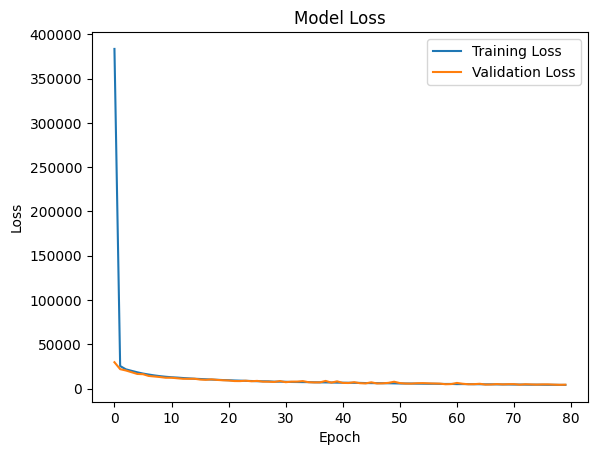

In [14]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### Make predictions

In [15]:
import numpy as np
predictions = model.predict(X_test)
predictions[predictions < 0] = 0
flattened_predictions = [0 if (isinstance(pred, np.ndarray) and pred.item() < 0) else (0 if pred < 0 else pred.item() if isinstance(pred, np.ndarray) else pred) for pred in predictions]

print(f'Predicted Solar Energy Ouput: {flattened_predictions[:20]}')
print(f'Actual Solar Energy Output: {y_test[:20].values}')


1099/1099 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step
Predicted Solar Energy Ouput: [3331.132568359375, 1204.2685546875, 3321.641845703125, 3269.722900390625, 1801.05908203125, 1214.1541748046875, 3352.138916015625, 3346.743896484375, 1267.3087158203125, 3330.558349609375, 3218.687255859375, 2097.388916015625, 3318.830810546875, 3266.418212890625, 3335.248291015625, 3317.933837890625, 3335.21923828125, 2468.642822265625, 3310.831298828125, 2311.869140625]
Actual Solar Energy Output: [3368. 1245. 3367. 3370. 1777. 1235. 3369. 3361. 1238. 3350. 3202. 2121.
 3365. 3319. 3365. 3365. 3337. 2486. 3342. 2481.]


In [16]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming predictions and y_test are numpy arrays or pandas series
# predictions = model.predict(X_test)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, predictions)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
average_y_test = np.mean(y_test)
percent_error = mae / average_y_test

# Display results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Percent Error (PERR): {percent_error}")

Mean Absolute Error (MAE): 42.220540974385266
Mean Squared Error (MSE): 4609.214762208387
Root Mean Squared Error (RMSE): 67.8911979729949
Percent Error (PERR): 0.01452434835724844


### Save model

In [17]:
model.save('NuclearModel.h5')